In [3]:
#Label the data
import pandas as pd
import numpy as np

y= pd.read_csv("/content/Labels.csv")
#Volatility
y['log_returns'] = y['Close'].rolling(window=2).apply(lambda x: np.log(x.iloc[1]/x.iloc[0]))
y['variance'] = y['log_returns'].rolling(window=10).var() # ==> Variance calculation 
y['variance'].fillna(0, inplace=True)
# Direction of the market
y['market_direction'] = y['Close'].rolling(window=2).apply(lambda x: 1 if x.iloc[1] >= x.iloc[0] else 0)

 
y['market_direction'].fillna(0, inplace=True)
# Labelling
y_Volatility = y.reset_index()['variance'] *1000
y_Direction = y.reset_index()['market_direction']

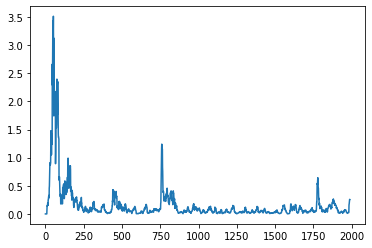

In [4]:
from matplotlib import pyplot as plt 
plt.plot(y_Volatility)

In [5]:
# Text data pre-processing
import nltk 
from nltk.corpus import stopwords
from nltk import stem
nltk.download('stopwords')

news_data =pd.read_csv("/content/Combined_News_DJIA.csv")
x= news_data.drop(['Label','Date'], axis=1)
x.columns = [str(c) for c in range(25)]

for i in x.columns:
    df = x[i].str.strip()     
    df = df.str.replace(' ', '_')   
    df= df.str.replace(r'b\'', '')
    df= df.str.replace(r'b\"', '')    
    df = df.str.replace(r"[^0-9a-zA-Z\_]+", "")
    df = df.str.replace('_+', ' ')  
    x[i]= df.str.lower()

x["combined_news"] = x.apply(lambda x: ''.join(str(x.values)), axis=1)
stopwords = nltk.corpus.stopwords.words('english')
ps = stem.PorterStemmer()

def clean_stem_stopWords(line: str ):
  return ' '.join(ps.stem(word) for word in line.split() if not word in stopwords)
x["combined_news"] = x["combined_news"].apply(lambda x: clean_stem_stopWords(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


1989


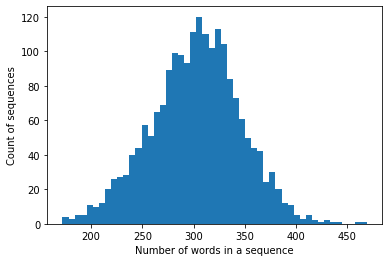

In [6]:
# Print the distribution of the sequence lengths
seq_len = [len(i.split()) for i in x["combined_news"]]
from matplotlib import pyplot as plt
print(len(seq_len))
plt.hist(pd.Series(seq_len),bins = 50)
plt.xlabel("Number of words in a sequence")
plt.ylabel("Count of sequences")

plt.show()

In [7]:
# simple tokenizer and padding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

MAX_SEQUENCE_LENGTH = 350
MAX_NUM_WORDS = 10000

tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(x["combined_news"])
data = tokenizer.texts_to_sequences(x["combined_news"])
data = pad_sequences(data, maxlen=MAX_SEQUENCE_LENGTH, padding='post')
print(data.shape)

(1989, 350)


In [8]:
data[0].shape

(350,)

In [9]:
# BOW
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.sequence import pad_sequences

MAX_NUM_WORDS = 10000 # number of features

countvector=CountVectorizer(ngram_range=(2,2), stop_words='english',max_features=MAX_NUM_WORDS)
traindataset=countvector.fit_transform(x["combined_news"])

print(traindataset.shape)


(1989, 10000)


In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#scaler
sc_X = StandardScaler()
X = sc_X.fit_transform(traindataset.toarray())

# PCA
pca=PCA(n_components=150)
X_pca = pca.fit_transform(X)

In [11]:
# choose right objective
y= y_Volatility

# Splitting the data:
num_validation_samples = 100
x_train = X_pca[:-num_validation_samples]
x_val = X_pca[-num_validation_samples:]
y_train = y[:-num_validation_samples]
y_val = y[-num_validation_samples:]

train mse 0.12203642198569271
val mse 0.015816740243063614
train score 0.0745599940500673
val score -3.4893045173538573


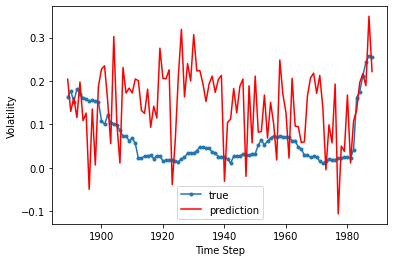

In [12]:
# Simple Linear Regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

# select the model with K-fold validation to see the std error
model = LinearRegression()
model.fit(x_train,y_train)

y_pred= model.predict(x_val)
y_train_pred= model.predict(x_train)

print("train mse", mean_squared_error(y_train, y_train_pred))
print("val mse", mean_squared_error(y_val, y_pred))
print("train score", model.score(x_train, y_train))
print("val score", model.score(x_val, y_val))


plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction")
plt.ylabel('Volatility')
plt.xlabel('Time Step')
#plt.ylim(0,5)
plt.savefig("LR.png")
plt.legend()
plt.show();


In [16]:
# Linear Regression with K-fold to get std
from sklearn.linear_model import LinearRegression
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import KFold
from matplotlib import pyplot as plt

# select the model with K-fold validation to see the std error
#model = LinearRegression()
model = KernelRidge()
#model = SVR(kernel='linear', max_iter=100)

trains = []
scores = []
cv = KFold(n_splits=10, shuffle=False)
for train_index, test_index in cv.split(X_pca):
    X_train, X_test, y_train, y_test = np.array(X_pca)[train_index], np.array(X_pca)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    model.fit(X_train, y_train)
    scores.append(mean_squared_error(model.predict(X_test), y_test )) # add  squared=True for RMSE
    trains.append(mean_squared_error(model.predict(X_train), y_train))

print(" TRAIN mean score with std error:", np.mean(trains), np.var(trains))
print(" TEST mean score with std error:", np.mean(scores), np.var(scores))



 TRAIN mean score with std error: 0.14085913534723746 0.0016716531816733278
 TEST mean score with std error: 0.21971523738384943 0.14912787016636436


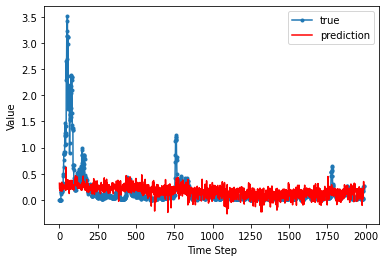

In [15]:
# Compare Prediction results on train + validation data
plt.plot( y , marker='.', label="true")
plt.plot( np.append(y_train_pred,y_pred), 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(0,5)
plt.legend()
plt.show();

train mse 1.5058254281690001e-07
val mse 2.6560912176658003e-08
train score -0.14191408640910197
val score -6.5388494207586305


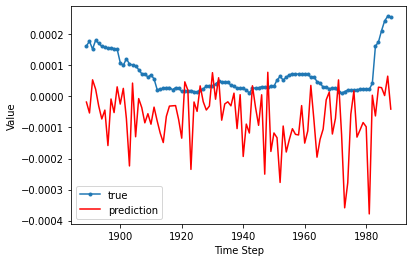

In [74]:
#KernelRidge
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt

# select the model
model = KernelRidge() #try kernel='rbf' but not great comparitively
model.fit(x_train,y_train)

y_pred= model.predict(x_val)
y_train_pred= model.predict(x_train)

print("train mse", mean_squared_error(y_train, y_train_pred))
print("val mse", mean_squared_error(y_val, y_pred))
print("train score", model.score(x_train, y_train))
print("val score", model.score(x_val, y_val))

plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(0,5)
plt.savefig("KernelRidge.png")
plt.legend()
plt.show();

train mse 2.6531165536597644e-06
val mse 2.8631160068979612e-06
train score -19.11940500429135
val score -811.6453002294182


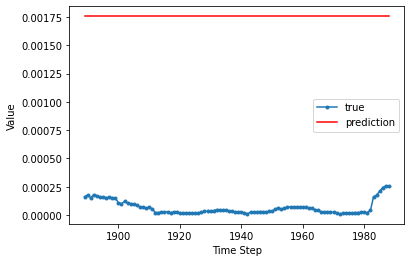

In [76]:
#SVR Support Vector Regression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

# select the model
model = SVR(kernel='linear',max_iter=150) #kernel='rbf'
model.fit(x_train,y_train)

y_pred= model.predict(x_val)
y_train_pred= model.predict(x_train)

print("train mse", mean_squared_error(y_train, y_train_pred))
print("val mse", mean_squared_error(y_val, y_pred))
print("train score", model.score(x_train, y_train))
print("val score", model.score(x_val, y_val))

plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(0,5)
plt.savefig("SVR.png")
plt.legend()
plt.show();


In [20]:
# MLP
from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout

def train_predict_MLP_model(x_train, y_train, x_val):


  input_shape = ( 150,)

  # Create the model
  model = Sequential()
  model.add(Dense(50, input_shape=input_shape, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(10,  activation='relu'))
  model.add(Dropout(0.2))

  # mean_square_error and linear activation function for regression problem.
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse'])
  #fit the model and statistics are stored in history for analysis
  history = model.fit(x_train, y_train, epochs=50, batch_size=10, verbose=1, validation_split=0.2)
  return model.predict(x_val)


In [21]:
trains = []
scores = []
cv = KFold(n_splits=10, shuffle=False)
for train_index, test_index in cv.split(X_pca):
    X_train, X_test, y_train, y_test = np.array(X_pca)[train_index], np.array(X_pca)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    
    y_pred= train_predict_MLP_model(X_train, y_train, X_test)
    scores.append(mean_squared_error(y_pred, y_test )) # add  squared=True for RMSE
    trains.append(mean_squared_error(model.predict(X_train), y_train))

print(" TRAIN mean score with std error:", np.mean(trains), np.var(trains))
print(" TEST mean score with std error:", np.mean(scores), np.var(scores))

Epoch 1/50
144/144 [==============================] - 1s 4ms/step - loss: 0.1877 - mse: 0.1877 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 2/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0232 - mse: 0.0232 - val_loss: 0.0152 - val_mse: 0.0152
Epoch 3/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0169 - mse: 0.0169 - val_loss: 0.0093 - val_mse: 0.0093
Epoch 4/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0158 - mse: 0.0158 - val_loss: 0.2287 - val_mse: 0.2287
Epoch 5/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0270 - mse: 0.0270 - val_loss: 0.0108 - val_mse: 0.0108
Epoch 6/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0152 - mse: 0.0152 - val_loss: 0.0092 - val_mse: 0.0092
Epoch 7/50
144/144 [==============================] - 0s 2ms/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0099 - val_mse: 0.0099
Epoch 8/50
144/144 [==============================] - 0s 3ms/step - loss: 0.

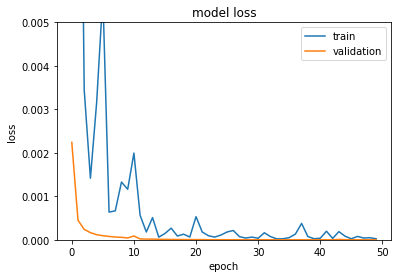

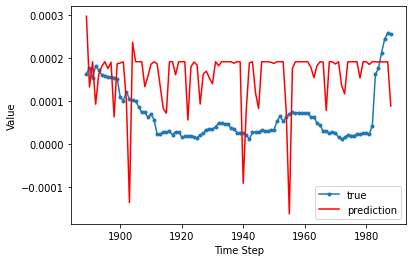

In [50]:
# Results with MLP
y_pred= model.predict(x_val)

from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim(0,0.005)
plt.legend(['train', 'validation'], loc='upper right')
plt.savefig('Price_MLP_val_2.png')
plt.show()

plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_val, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_val)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
#plt.ylim(-.001,0.001)
plt.savefig("Price_MLP_2.png")
plt.legend()
plt.show();

In [23]:
# Convert the data shape into 3-Dimensional for LSTM

x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
x_val =x_val.reshape(x_val.shape[0],x_val.shape[1] , 1)

In [55]:
x_train.shape

(1889, 150, 1)

In [27]:
#LSTM

from keras.models import Sequential
from keras.layers import Dense, Embedding, BatchNormalization, Dropout, LSTM

def train_predict_LSTM_model(x_train, y_train, x_val ):
  x_train =x_train.reshape(x_train.shape[0],x_train.shape[1] , 1)
  x_val =x_val.reshape(x_val.shape[0],x_val.shape[1] , 1)
  input_shape = ( 150,1)

  # Create the model
  model = Sequential()
  model.add(LSTM(30, dropout=0.15, activation ='relu', input_shape=input_shape))
  model.add(Dense(1, activation='linear'))
  model.compile(loss='mean_squared_error', optimizer='SGD', metrics=['mse'])

  #fit the model and statistics are stored in history for analysis
  history = model.fit(x_train, y_train, epochs=20, batch_size=10, verbose=1, validation_split=0.2)

  #Results with LSTM
  return model.predict(x_val)

trains = []
scores = []
cv = KFold(n_splits=3, shuffle=False)
for train_index, test_index in cv.split(X_pca):
    X_train, X_test, y_train, y_test = np.array(X_pca)[train_index], np.array(X_pca)[test_index], np.array(y)[train_index], np.array(y)[test_index]
    
    y_pred= train_predict_LSTM_model(X_train, y_train, X_test)
    scores.append(mean_squared_error(y_pred, y_test )) # add  squared=True for RMSE
    trains.append(mean_squared_error(model.predict(X_train), y_train))

print(" TRAIN mean score with std error:", np.mean(trains), np.var(trains))

print(" TEST mean score with std error:", np.mean(scores), np.var(scores))

Epoch 1/20
106/106 [==============================] - 4s 41ms/step - loss: 0.0190 - mse: 0.0190 - val_loss: 0.0136 - val_mse: 0.0136
Epoch 2/20
106/106 [==============================] - 4s 38ms/step - loss: 0.0179 - mse: 0.0179 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 3/20
106/106 [==============================] - 4s 38ms/step - loss: 0.0171 - mse: 0.0171 - val_loss: 0.0132 - val_mse: 0.0132
Epoch 4/20
106/106 [==============================] - 4s 37ms/step - loss: 0.0170 - mse: 0.0170 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 5/20
106/106 [==============================] - 4s 39ms/step - loss: 0.0166 - mse: 0.0166 - val_loss: 0.0127 - val_mse: 0.0127
Epoch 6/20
106/106 [==============================] - 4s 37ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0128 - val_mse: 0.0128
Epoch 7/20
106/106 [==============================] - 4s 38ms/step - loss: 0.0165 - mse: 0.0165 - val_loss: 0.0126 - val_mse: 0.0126
Epoch 8/20
106/106 [==============================] - 4s 39ms/step - 